## Multi-platform, multi-modal bayesian optimized coupled auto-encoder analysis 

In this notebook, we will present the analysis of ~50k cells coming from IVSCC, ME, EM and fMOST piplines. 


In [3]:
# From python
import numpy as np
import pandas as pd
import scipy.io as sio
from tabulate import tabulate
import matplotlib.pyplot as plt
from collections import Counter

# From cplAE_MET
from cplAE_MET.utils.plots import plot_z_3d, plot_m
from cplAE_MET.utils.optuna_helpers import load_study
from cplAE_MET.utils.analysis_helpers import load_exp_output
from cplAE_MET.utils.analysis_helpers import get_Leiden_comms
from cplAE_MET.utils.analysis_helpers import summary_classification_results
from cplAE_MET.utils.analysis_helpers import summary_leiden_comm_silhouette_score
from cplAE_MET.utils.analysis_helpers import summarize_data_output_pkl


# From optuna
from optuna.visualization import plot_parallel_coordinate

dat = "/home/fahimehb/Remote-AI-root/allen/programs/celltypes/workgroups/mousecelltypes/MachineLearning/Patchseq-Exc/dat/"
# input_mat = sio.loadmat(dat + "MET_data_MPCs_with_mass_normalized_Mfeatures_wout_Mcells_with_onlyMfeatures_13Mar23.mat")

Summarizing a model with 10k cells for NIH presentation. Since I was not printing the platform and class of the cells in the output pkl file, I need to read it from the input file. The input file that was used is the "exc_inh_ME_fMOST_EM_specimen_ids_13Mar23.txt". I should not trust the T_cell, E_cell and M_cell columns in this file however. For that I will use the output file to see which modalities were available for each cell.

In [9]:
# platform of all the cells in the 10k model
platforms = pd.read_csv(dat + "exc_inh_ME_fMOST_EM_specimen_ids_13Mar23.txt")[["specimen_id", "platform"]]
platforms.head()

,specimen_id,platform
0,823231829,patchseq
1,893406540,patchseq
2,896877084,patchseq
3,912008949,patchseq
4,921685533,patchseq


In [11]:
#output
output = load_exp_output(exp_name="MET_patch_ME_EM_fMOST_merged_t_type_at50_classification_optimization_v1", pkl_file="Results_trial_671.pkl")
output.keys()

dict_keys(['XT', 'XM', 'XE', 'XrT', 'XrE', 'XrM', 'XrM_me_paired', 'XrE_me_paired', 'zm', 'ze', 'zt', 'zme_paired', 'is_t_1d', 'is_e_1d', 'is_m_1d', 'cluster_id', 'gene_ids', 'e_features', 'specimen_id', 'cluster_label', 'merged_cluster_label_at40', 'merged_cluster_label_at50', 'cluster_color', 'train_ind', 'val_ind'])

In [20]:
df = pd.DataFrame.from_dict({'specimen_id': output['specimen_id'], 
                             'is_t_1d': output['is_t_1d'], 
                             'is_e_1d': output['is_e_1d'], 
                             'is_m_1d': output['is_m_1d'],
                             'is_te_1d': False,
                             'is_tm_1d': False,
                             'is_me_1d': False,
                             'is_met_1d': False,
                             'is_t_only': False,
                             'is_e_only': False,
                             'is_m_only': False,
                             'is_te_only': False,
                             'is_tm_only': False,
                             'is_me_only': False})

df.loc[(df['is_t_1d']) & (df['is_e_1d']), 'is_te_1d'] = True
df.loc[(df['is_t_1d']) & (df['is_m_1d']), 'is_tm_1d'] = True
df.loc[(df['is_m_1d']) & (df['is_e_1d']), 'is_me_1d'] = True
df.loc[(df['is_e_1d']) & (df['is_tm_1d']), 'is_met_1d'] = True
df.loc[(df['is_t_1d']) & (~df['is_e_1d']) & (~df['is_m_1d']), 'is_t_only'] = True
df.loc[(df['is_e_1d']) & (~df['is_t_1d']) & (~df['is_m_1d']), 'is_e_only'] = True
df.loc[(df['is_m_1d']) & (~df['is_e_1d']) & (~df['is_t_1d']), 'is_m_only'] = True
df.loc[(df['is_te_1d']) & (~df['is_m_1d']), 'is_te_1d'] = True
df.loc[(df['is_tm_1d']) & (~df['is_e_1d']), 'is_tm_1d'] = True
df.loc[(df['is_me_1d']) & (~df['is_t_1d']), 'is_me_1d'] = True
df = df.merge(platforms, on="specimen_id")
df.head()

,specimen_id,is_t_1d,is_e_1d,is_m_1d,is_te_1d,is_tm_1d,is_me_1d,is_met_1d,is_t_only,is_e_only,is_m_only,is_te_only,is_tm_only,is_me_only,platform
0,823231829,True,True,False,True,False,False,False,False,False,False,False,False,False,patchseq
1,893406540,True,True,False,True,False,False,False,False,False,False,False,False,False,patchseq
2,896877084,True,True,False,True,False,False,False,False,False,False,False,False,False,patchseq
3,912008949,True,True,False,True,False,False,False,False,False,False,False,False,False,patchseq
4,921685533,True,True,True,True,True,True,True,False,False,False,False,False,False,patchseq


In [34]:
summary = pd.DataFrame(columns=["platform", "T", "E", "M", "T&E", "T&M", "M&E", "M&E&T"])
for i, p in enumerate(["patchseq", "ME", "fMOST", "EM"]):
    summary.loc[i, 'platform'] = p
    summary.loc[i, "T" ] = df[df['platform']==p].drop(columns=['specimen_id', 'platform']).sum(axis=0)['is_t_only']
    summary.loc[i, "E" ] = df[df['platform']==p].drop(columns=['specimen_id', 'platform']).sum(axis=0)['is_e_only']
    summary.loc[i, "M" ] = df[df['platform']==p].drop(columns=['specimen_id', 'platform']).sum(axis=0)['is_m_only']
    summary.loc[i, "T&E" ] = df[df['platform']==p].drop(columns=['specimen_id', 'platform']).sum(axis=0)['is_te_only']
    summary.loc[i, "T&M" ] = df[df['platform']==p].drop(columns=['specimen_id', 'platform']).sum(axis=0)['is_tm_only']
    summary.loc[i, "M&E" ] = df[df['platform']==p].drop(columns=['specimen_id', 'platform']).sum(axis=0)['is_me_only']
    summary.loc[i, "M&E&T" ] = df[df['platform']==p].drop(columns=['specimen_id', 'platform']).sum(axis=0)['is_met_1d']
    # summary.loc[i, "total" ] = df[df['platform']==p].drop(columns=['specimen_id', 'platform']).sum(axis=0)['is_t_1d']
summary


,platform,T,E,M,T&E,T&M,M&E,M&E&T
0,patchseq,554,0,2,0,0,0,1413
1,ME,0,1485,3,0,0,0,0
2,fMOST,0,0,280,0,0,0,0
3,EM,0,0,479,0,0,0,0


In [4]:
    df = pd.DataFrame.from_dict({'cluster_label': [i.rstrip() for i in input_mat['cluster_label']], 
                             'cluster_color': [i.rstrip() for i in input_mat['cluster_color']], 
                             'cluster_id': [i.rstrip() for i in input_mat['cluster_id'].astype(str)[0]]
    })
df = df.loc[df['cluster_label']!="nan"]
df["cluster_id"] = df["cluster_id"].astype(float)
df = df.groupby(["cluster_id", "cluster_label", "cluster_color"])["cluster_label"].count().reset_index(name="count").sort_values(by=["cluster_id"])
df.head()

,cluster_id,cluster_label,cluster_color,count
0,2.0,L2/3 IT VISp Rrad,#D9F077,75
1,4.0,L2/3 IT VISp Adamts2,#A6E6A9,7
2,5.0,L2/3 IT VISp Agmat,#7AE6AB,97
3,6.0,L4 IT VISp Rspo1,#00979D,136
4,9.0,L5 IT VISp Hsd11b1 Endou,#00DDC5,154


In [5]:
df['count'].sum()

6552

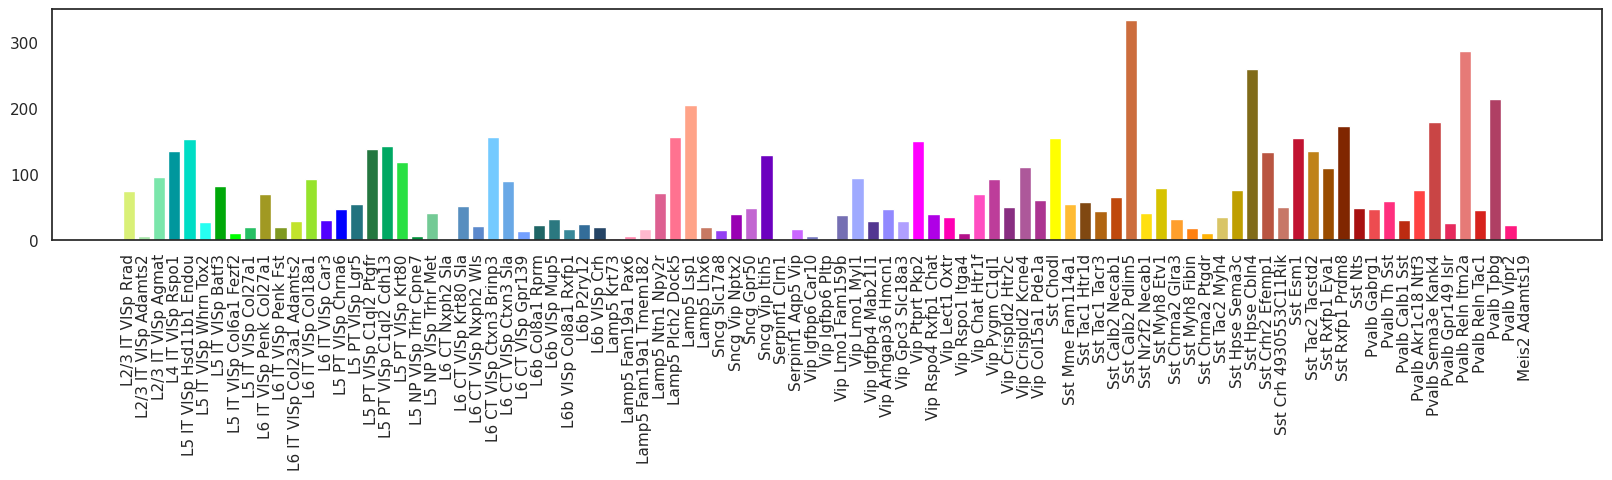

In [6]:
plt.figure(figsize=(20,3))
plt.bar(range(len(df['cluster_label'])), list(df['count']), color=list(df['cluster_color']), align="center")
plt.xticks(range(len(df['cluster_label'])), list(df['cluster_label']), rotation=90)
plt.show()

Text(0.5, 0, 'M features(xm)')

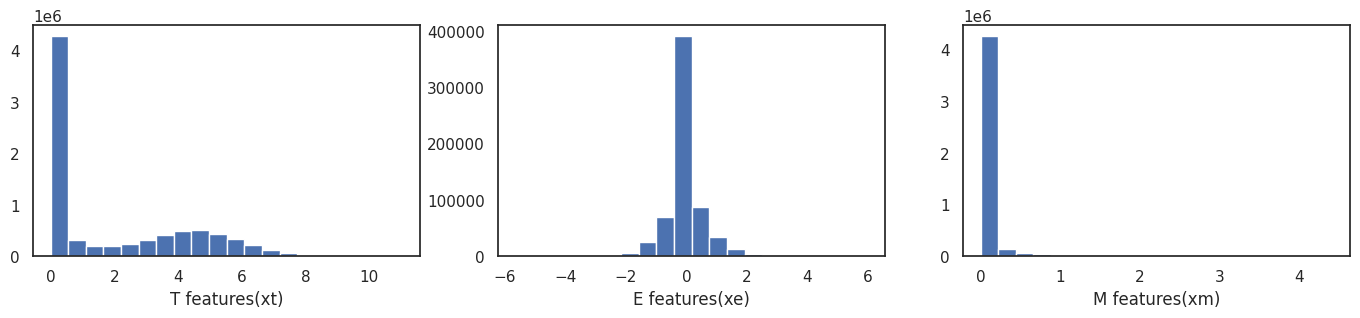

In [7]:
is_t_1d = np.all(~np.isnan(input_mat['T_dat']), axis=1)
is_e_1d = np.all(~np.isnan(input_mat['E_dat']), axis=1)
is_m_1d = np.all(~np.isnan(input_mat['M_dat']), axis=1)

# input data histograms
fig, axs = plt.subplots(1,3, figsize=(17, 3))
_ = axs[0].hist(input_mat['T_dat'][is_t_1d].flatten(), bins=20)
_ = axs[1].hist(input_mat['E_dat'][is_e_1d].flatten(), bins=20)
_ = axs[2].hist(input_mat['M_dat'][is_m_1d].flatten(), bins=20)
axs[0].set_xlabel("T features(xt)")
axs[1].set_xlabel("E features(xe)")
axs[2].set_xlabel("M features(xm)")

In [5]:
study = load_study("MET_patch_ME_EM_fMOST_merged_t_type_at50_classification_optimization_v1")
study.best_trial.number

[I 2023-04-06 08:41:42,738] Using an existing study with name 'MET_patch_ME_EM_fMOST_merged_t_type_at50_classification_optimization_v1' instead of creating a new one.


2080

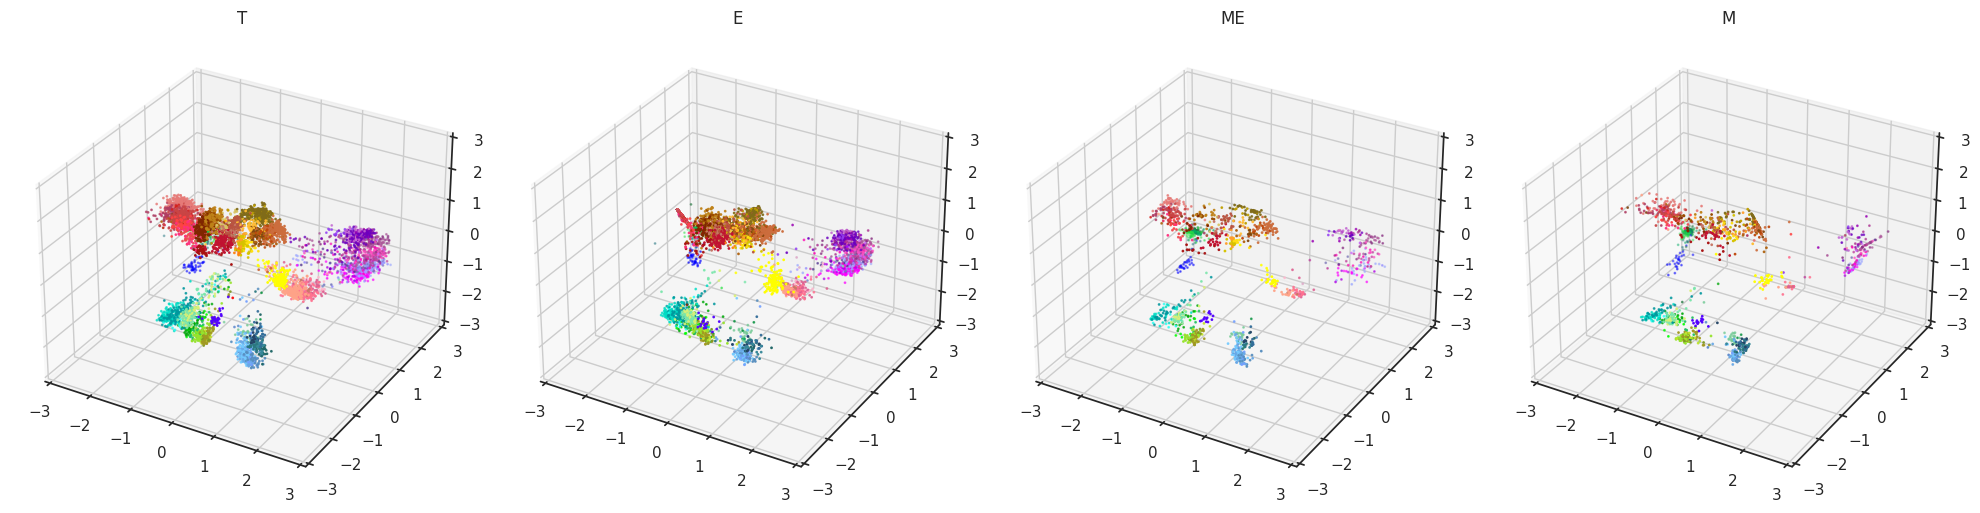

10fold cross_validated Classification acc at different levels:
+----+--------------+----------------+-----------------+----------------+
|    |   t_clusters |   et_class_acc |   met_class_acc |   mt_class_acc |
|----+--------------+----------------+-----------------+----------------|
|  0 |           93 |          45.36 |           53.96 |          45.02 |
|  0 |           59 |          64.57 |           76.82 |          68.18 |
|  0 |           50 |          68.1  |           83.62 |          74.15 |
+----+--------------+----------------+-----------------+----------------+


In [5]:
output = load_exp_output(exp_name="MET_patch_ME_EM_fMOST_merged_t_type_at50_classification_optimization_v1", pkl_file="Results_trial_671.pkl")
plot_z_3d(output, xlim=(-3,3), ylim=(-3, 3), zlim=(-3,3))
print("10fold cross_validated Classification acc at different levels:")
print(tabulate(summary_classification_results(output), headers = 'keys', tablefmt = 'psql'))

In [8]:
plot_parallel_coordinate(study)

NameError: name 'plot_parallel_coordinate' is not defined

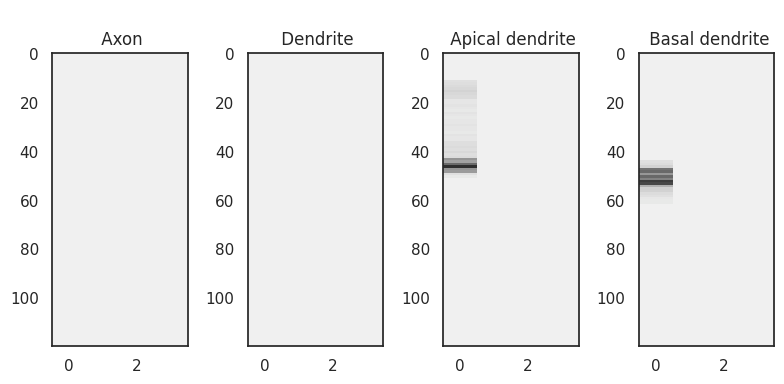

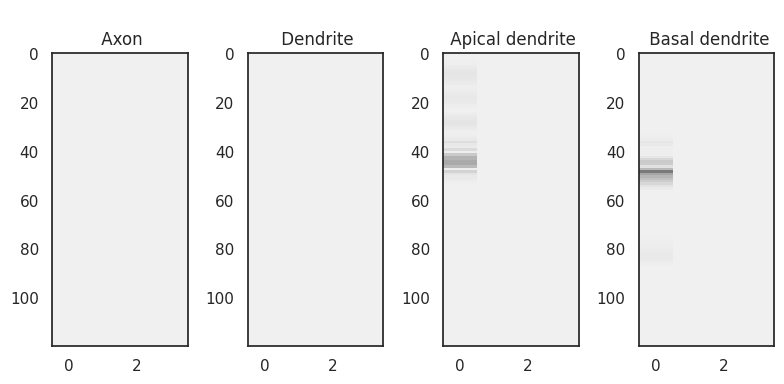

In [9]:
plot_m(output['hist_ax_de_api_bas'][output['is_m_1d']][1200,...])
plot_m(output['rec_arbor_density'][output['is_m_1d']][1200,...])

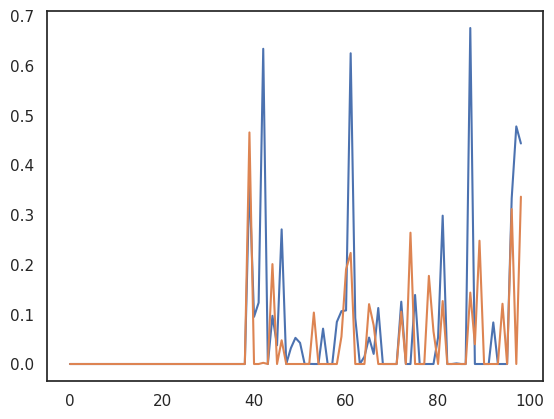

In [15]:
plt.plot(output['XM'][output['is_m_1d']][1000,...])
plt.plot(output['XrM'][output['is_m_1d']][1000,...])